In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import copy
import time
from astropy import units as u
from astropy.constants import G
from astropy.io import ascii
from matplotlib import gridspec

% matplotlib inline

<img src="files/dressing.png" style="width: 700px;">

In [45]:
6.6e4 * 3.e-6

0.198

## Goal: Get planet occurrence rate data from Dressing & Charbonneau 2013: https://arxiv.org/abs/1302.1647

### These are planets with P < 50d orbiting late K and M stars in the Kepler survey, so these are occurrence rates for short-period planets.

| Radius range [R_Earth] | Mass range [M_Earth] | Mass range [M_Sun] | Occurrence rate    |
|------------------------|----------------------|--------------------|--------------------|
| 0.5-0.7                | 0.06 - 0.4           | 1.8e-7 - 1.2e-6    | 0.014+0.0129-0.006 |
| 0.7-1.0                | 0.2 - 1.8            | 6.e-7 - 5.4e-6     | 0.212+0.0590-0.044 |
| 1.0-1.4                | 0.7 - 4.4            | 2.1e-6 - 1.3e-5    | 0.285+0.0509-0.041 |
| 1.4-2.0                | 1.9 - 8.6            | 5.7e-6 - 2.6e-5    | 0.202+0.0443-0.035 |
| 2.0-2.8                | 3.1 - 15.5           | 9.3e-6 - 4.7e-5    | 0.186+0.0440-0.034 |
| 2.8-4.0                | 5.1 - 24.9           | 1.5e-5 - 7.5e-5    | 0.005+0.0081-0.003 |
| 4.0-5.7                | 9.6 - 47.4           | 2.9e-5 - 1.4e-4    | 0.004+0.0062-0.002 |
| 8.0-11.3               | 31.3 - 1.54e4        | 9.4e-5 - 4.6e-2    | 0.003+0.0044-0.001 |
| 11.3-16.0              | 190 -  3.1e4         | 5.7e-4 - 9.3e-2    | 0.004+0.0055-0.002 |
| 16.0-22.6              | 145 -  6.6e4         | 4.3e-4 - 2.0e-1    | 0.003+0.0041-0.001 |


### In the above table, I have used Chen & Kipping's Forecaster model (https://arxiv.org/abs/1603.08614) to make a rough conversion of Earth radii to Earth masses.

0.5 Rearth: M = 0.085 (+ 0.029 - 0.023) MEarth

0.7 Rearth: M = 0.274 (+ 0.081 - 0.067) MEarth

1.0 Rearth: M = 1.021 (+ 0.767 - 0.333) MEarth

1.4 Rearth: M = 2.822 (+ 1.540 - 0.958) MEarth

2.0 Rearth: M = 4.940 (+ 3.709 - 1.810) MEarth

2.8 Rearth: M = 8.127 (+ 7.332 - 2.978) MEarth

4.0 Rearth: M = 16.452 (+ 8.458 - 6.858) MEarth

5.7 Rearth: M = 30.658 (+ 16.725 - 13.150) MEarth

8.0 Rearth: M = 59.526 (+ 5416.360 - 28.232) MEarth

11.3 Rearth: M = 2246.382 (+ 13200.998 - 2056.206) MEarth

16.0 Rearth: M = 608.760 (+ 30019.274 - 463.531) MEarth

22.6 Rearth: M = 57661.604 (+ 8318.868 - 56944.355) MEarth

### The occurrence rate $f$ is in units of number of planets/star, so we need to multiply by the number density of M dwarfs in the Kepler field.

For now, take this number density to be the number density in the solar neighborhood: from Bonfils et al. 2013, this is $\frac{102}{1.12*10^4} = 9.1*10^{-3}$.

## individual bins

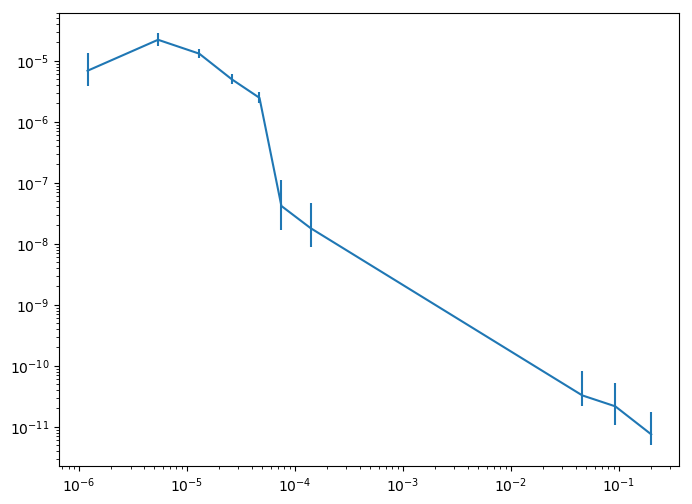

In [46]:
#If a sequence of shape 2xN, errorbars are drawn at -row1 and +row2 relative to the data.
mbins_lower = np.array((1.8e-7,6.0e-7,2.1e-6,5.7e-6,9.3e-6,1.5e-5,2.9e-5,9.4e-5,5.7e-4,4.3e-4))
mbins_upper = np.array((1.2e-6,5.4e-6,1.3e-5,2.6e-5,4.7e-5,7.5e-5,1.4e-4,4.6e-2,9.3e-2,2.0e-1))

mbins_intervals = mbins_upper - mbins_lower

fbins_indiv = (9.1e-3 * np.array((0.014,0.212,0.285,0.202,0.186,0.005,0.004,0.003,0.004,0.003))) / mbins_intervals
fbins_upperunc_indiv = (9.1e-3 * np.array((0.0129,0.0590,0.0509,0.0443,0.0440,0.0081,0.0062,0.0044,0.0055,0.0041))) / mbins_intervals
fbins_lowerunc_indiv = (9.1e-3 * np.array((0.006,0.044,0.041,0.035,0.034,0.003,0.002,0.001,0.002,0.001))) / mbins_intervals

fbins_indiv_univ = 5.e-10 * np.array((0.014,0.212,0.285,0.202,0.186,0.005,0.004,0.003,0.004,0.003)) / mbins_intervals
fbins_upperunc_indiv_univ = 5.e-10 * np.array((0.0129,0.0590,0.0509,0.0443,0.0440,0.0081,0.0062,0.0044,0.0055,0.0041)) / mbins_intervals
fbins_lowerunc_indiv_univ = 5.e-10 * np.array((0.006,0.044,0.041,0.035,0.034,0.003,0.002,0.001,0.002,0.001)) / mbins_intervals

#take the average mass in each mass bin
mbins_indiv = mbins_intervals / 2.

#If a sequence of shape 2xN, errorbars are drawn at -row1 and +row2 relative to the data.
fig = plt.figure(figsize=(8,6))
plt.errorbar(mbins_upper, fbins_indiv_univ, yerr=np.vstack((fbins_lowerunc_indiv_univ,fbins_upperunc_indiv_univ)))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [47]:
transitBinsData =np.vstack((mbins_indiv,fbins_indiv,fbins_upperunc_indiv,fbins_lowerunc_indiv)).T
np.savetxt('../data/planetsTransitBins_M.txt',transitBinsData,fmt='%1.3e \t',header='M (M_s) \t dN/dMdV (M_s^-1 pc^-3) \t dN/dMdV_upperunc (M_s^-1 pc^-3) \t dN/dMdV_lowerunc (M_s^-1 pc^-3)')

In [48]:
transitBinsData_univ =np.vstack((mbins_indiv,fbins_indiv_univ,fbins_upperunc_indiv_univ,fbins_lowerunc_indiv_univ)).T
np.savetxt('../data/planetsTransitBins_M_univ.txt',transitBinsData_univ,fmt='%1.3e \t',header='M (M_s) \t dN/dMdV (M_s^-1 pc^-3) \t dN/dMdV_upperunc (M_s^-1 pc^-3) \t dN/dMdV_lowerunc (M_s^-1 pc^-3)')